## Recurrent Neural Networks
    - This is a implementation from scratch of recurrent neural networks
    - Used Numpy for matrix functions
* Author: Jonver Oro

In [1]:
# import modules
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
import sklearn.datasets
from math import log
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

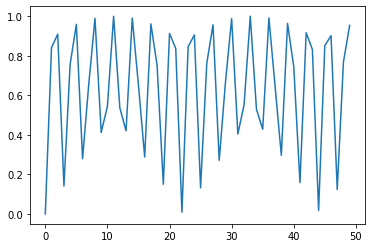

In [2]:
data_size = 500
sin_wave = np.array([abs(math.sin(x)) for x in np.arange(data_size)])
timestep = data_size
plt.plot(sin_wave[:50])

In [11]:
X = []
Y = []

seq_len = 100
num_records = len(sin_wave) - seq_len

for i in range(num_records- 50):
    X.append(sin_wave[i:i+seq_len])
    Y.append(sin_wave[i+seq_len])
    
X = np.array(X)
X = np.expand_dims(X, axis=2)

Y = np.array(Y)
Y = np.expand_dims(Y, axis=1)
print(X.shape,Y.shape)

(350, 100, 1) (350, 1)


In [12]:
class activations:
    def relu(self,Z):
        R = np.maximum(0, Z)
        return R
    
    def sigmoid(self,Z):
        S = 1 / (1 + np.exp(-Z))
        return S
    
    def tanh(self,x):
        t=(np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))
        return t
    
    def d_tanh(self,t):
        dt=1-t**2
        return dt
    
    def d_sigmoid(self,Z):
        dS = Z * (1 - Z)
        return dS

    def d_relu(self,z):
        dZ= np.where(z <= 0, 0, 1)
        return dZ
    

In [13]:
#constant variables
learning_rate = 0.0001
epochs = 15
T = seq_len
hidden = 100
output = 1
bptt_lim = 5 # * limits how far on timestep you will do backward prop
min_clip_value = -10
max_clip_value = 10

In [14]:
# TRAIN NETWORK
# * weights
wu = np.random.uniform(0, 1, (hidden, T))
ww = np.random.uniform(0,1,(hidden,hidden))
wv = np.random.uniform(0,1,(output,hidden))
print(wu.shape)
print(ww.shape)
print(wv.shape)

# * traning loop
for e in range(0,epochs):
    loss = 0
    
    for n in range(Y.shape[0]):
        x, y = X[n], Y[n]
        prev_h = np.zeros((hidden,1))
        cache = []
        # derivatives
        
        d_wu = np.zeros(wu.shape)
        d_wv = np.zeros(wv.shape)
        d_ww = np.zeros(ww.shape)
        
        d_wu_t = np.zeros(wu.shape)
        d_wv_t = np.zeros(wv.shape)
        d_ww_t = np.zeros(ww.shape)
        
        d_wu_i = np.zeros(wu.shape)
        d_ww_i = np.zeros(ww.shape)
        
        # * time step loop forward pass
        for t in range(T):
            x_val = np.zeros(x.shape)
            x_val[t] = x[t] # * get only single x on shape of main x
            mul_u = np.dot(wu,x_val)
            mul_w = np.dot(ww,prev_h)
            v =  mul_u+mul_w
            h = activations().sigmoid(v)
            mul_v = np.dot(wv,h)
            cache.append({'h':h, 'prev_h':prev_h})
            prev_h = h
        
        # * timestep loop backward pass
        d_mulv = (mul_v - y) # * derivative of y
        
        for t in range(T):
            
            # * perform last layer activations derivative
            h = cache[t]['h']
            prev_h = cache[t]['prev_h']
            d_wv_t = np.dot(d_mulv,h.T)
            d_h = np.dot(wv.T,d_mulv)
            d_v_a = activations().d_sigmoid(v) *d_h
            d_mul_w = d_v_a * np.ones_like(mul_w)
            d_prev_h = np.dot(ww.T,d_v_a)
            
            # * loop for remaining layers derivative computations
            # * limit bptt to save computation timeß
            for i in range(t-1,bptt_lim-1,-1):
                ds = d_h + d_prev_h
                d_v_a = activations().d_sigmoid(v) * ds
                
                d_mul_w = d_v_a * np.ones_like(mul_w)
                d_mul_u = d_v_a * np.ones_like(mul_u)
                
                d_ww_i = np.dot(ww,cache[t]['prev_h'])
                d_prev_h = np.dot(ww.T,d_mul_w)
                
                n_x = np.zeros(x.shape)
                n_x[t] = x[t]
                d_wu_i = np.dot(wu,n_x)
                d_x = np.dot(wu.T,d_mul_u)
                
                d_wu_t += d_wu_i
                d_ww_t += d_ww_i
                
            d_wv += d_wv_t
            d_wu += d_wu_t
            d_ww += d_ww_t
            
            # * clip values to prevent exploding gradients
            
            if d_wu.max() > max_clip_value:
                d_wu[d_wu > max_clip_value] = max_clip_value
            if d_wv.max() > max_clip_value:
                d_wv[d_wv > max_clip_value] = max_clip_value
            if d_ww.max() > max_clip_value:
                d_ww[d_ww > max_clip_value] = max_clip_value
                
            
            if d_wu.min() < min_clip_value:
                d_wu[d_wu < min_clip_value] = min_clip_value
            if d_wv.min() < min_clip_value:
                d_wv[d_wv < min_clip_value] = min_clip_value
            if d_ww.min() < min_clip_value:
                d_ww[d_ww < min_clip_value] = min_clip_value
        
        
        loss_per_record = (y - v)**2 / 2
        loss += loss_per_record
        
        # update
        wu -= learning_rate * d_wu
        wv -= learning_rate * d_wv
        ww -= learning_rate * d_ww


    loss = np.mean(loss / float(y.shape[0]))
    print('Epoch: ', e, ', Loss: ', loss)

(100, 100)
(100, 100)
(1, 100)


/Users/jonvero/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: overflow encountered in multiply


Epoch:  0 , Loss:  199952.39535693158
Epoch:  1 , Loss:  5567.488071151431
Epoch:  2 , Loss:  109.07096301187738
Epoch:  3 , Loss:  109.08085128455318
Epoch:  4 , Loss:  108.9999985114373
Epoch:  5 , Loss:  109.31091668500594
Epoch:  6 , Loss:  109.02309945372781
Epoch:  7 , Loss:  108.98822557322765
Epoch:  8 , Loss:  109.00288762574186
Epoch:  9 , Loss:  108.95048597878336
Epoch:  10 , Loss:  109.08907377074105
Epoch:  11 , Loss:  109.03766760593702
Epoch:  12 , Loss:  108.97260718030228
Epoch:  13 , Loss:  109.05811495802268
Epoch:  14 , Loss:  108.96619882264672


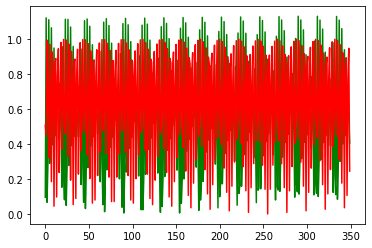

In [15]:
preds = []
for i in range(Y.shape[0]):
    x, y = X[i], Y[i]
    prev_s = np.zeros((hidden, 1))
    # Forward pass
    for t in range(T):
        mul_u = np.dot(wu, x)
        mul_w = np.dot(ww, prev_s)
        v = mul_w + mul_u
        h = activations().sigmoid(v)
        mulv = np.dot(wv, h)
        prev_s = h

    preds.append(abs(mulv))
    
preds = np.array(preds)

plt.plot(preds[:, 0, 0], 'g') # prediction
plt.plot(Y[:, 0], 'r') # actual values
plt.show()